In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn.linear_model as linear
import sklearn.metrics as metric
import sklearn.preprocessing as pre

import warnings
warnings.filterwarnings("ignore")

import wrangle as w
import evaluate as ev

In [2]:
zillow_outliers = w.wrangle_zillow(remove=False)

In [3]:
zillow_outliers.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,taxamount,fips,large_home,small_home,county,county_Orange,county_Ventura,2017_age
4,4,2,3633,296425.0,2005,6941.39,6037.0,False,False,LA,0,0,12
6,3,4,1620,847770.0,2011,10244.94,6037.0,False,False,LA,0,0,6
7,3,2,2077,646760.0,1926,7924.68,6037.0,False,False,LA,0,0,91
11,0,0,1200,5328.0,1972,91.60,6037.0,False,True,LA,0,0,45
14,0,0,171,6920.0,1973,255.17,6037.0,False,True,LA,0,0,44


In [4]:
zillow_outliers.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   bedrooms        2140235 non-null  int64  
 1   bathrooms       2140235 non-null  int64  
 2   square_feet     2140235 non-null  int64  
 3   tax_value       2140235 non-null  float64
 4   year_built      2140235 non-null  int64  
 5   taxamount       2140235 non-null  float64
 6   fips            2140235 non-null  float64
 7   large_home      2140235 non-null  bool   
 8   small_home      2140235 non-null  bool   
 9   county          2140235 non-null  object 
 10  county_Orange   2140235 non-null  uint8  
 11  county_Ventura  2140235 non-null  uint8  
 12  2017_age        2140235 non-null  int64  
dtypes: bool(2), float64(3), int64(5), object(1), uint8(2)
memory usage: 171.5+ MB


In [5]:
zillow_outliers.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
bedrooms,2140235.0,NaN,NaN,NaN,3.301419,0.9326,0.0,3.0,3.0,4.0,25.0
bathrooms,2140235.0,NaN,NaN,NaN,2.186612,0.973504,0.0,2.0,2.0,3.0,32.0
square_feet,2140235.0,NaN,NaN,NaN,1863.19397,1221.754161,1.0,1258.0,1623.0,2208.0,952576.0
tax_value,2140235.0,NaN,NaN,NaN,460641.625164,677157.635675,22.0,189166.0,328296.0,534606.0,90188462.0
year_built,2140235.0,NaN,NaN,NaN,1960.967545,22.150563,1801.0,1949.0,1958.0,1976.0,2016.0
taxamount,2140235.0,NaN,NaN,NaN,5616.711322,7814.562798,6.34,2540.85,4111.47,6411.93,1078101.87
fips,2140235.0,NaN,NaN,NaN,6048.309556,20.34491,6037.0,6037.0,6037.0,6059.0,6111.0
large_home,2140235,2,False,2019146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
small_home,2140235,2,False,2112157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
county,2140235,3,LA,1425207,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train, validate, test = w.split_data(zillow_outliers)

In [7]:
train_scaled, validate_scaled, test_scaled = w.scale_zillow(train, validate, test)

In [8]:
train_scaled.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,taxamount,fips,large_home,small_home,county,county_Orange,county_Ventura,2017_age
894766,3,2,-0.471004,424000.0,1958,0.360223,6037.0,False,False,LA,0,0,59
1229589,3,2,-1.207869,381638.0,1976,0.374392,6037.0,False,False,LA,0,0,41
319895,3,2,-0.274391,280030.0,1958,-0.336546,6059.0,False,False,Orange,1,0,59
548848,3,3,0.689529,249000.0,2005,0.341149,6037.0,False,False,LA,0,0,12
152577,4,3,0.659334,336285.0,1963,0.053724,6037.0,False,False,LA,0,0,54


In [9]:
def prep_for_model(train, validate, test, target):
    '''
    Takes in train, validate, and test data frames
    then splits  for X (all variables but target variable) 
    and y (only target variable) for each data frame
    '''

    X_train = train.drop(columns=target)
    y_train = train[target]

    X_validate = validate.drop(columns=target)
    y_validate = validate[target]

    X_test = test.drop(columns=target)
    y_test = test[target]

    return X_train, y_train, X_validate, y_validate, X_test, y_test


In [10]:
def big_zillow_wrangle(target, new = False, remove = True):
    '''
    Takes in the target variable, if you want new data, and 
    if you want to remove outliers. 
    Returns a cleaned zillow dataframe and split dataframe ready for 
    exploration and modeling
    '''
    #acquire data
    mydf = w.aquire_zillow_data(new = new)
    #clean data
    mydf = w.clean_zillow(mydf, remove = remove)
    #split data
    train, validate, test = w.split_data(mydf)
    #scale data
    train_scaled, validate_scaled, test_scaled = w.scale_zillow(train, validate, test)
    #prep for model
    X_train, y_train, X_validate, y_validate, X_test, y_test = w.prep_for_model(train_scaled, validate_scaled, test_scaled, target)
    #explore data
    X_train_exp = train.drop(columns=target)
    
    return mydf, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test





## Let's try leaving in outliers

In [11]:
mydf, X_train_exp, X_train, \
y_train, X_validate, y_validate, \
X_test, y_test = w.big_zillow_wrangle('tax_value', remove=False)

In [12]:
mydf.shape

(2140235, 13)

In [13]:
X_train.shape

(1391152, 9)

In [14]:
X_train.head()

,bedrooms,bathrooms,square_feet,year_built,taxamount,fips,county_Orange,county_Ventura,2017_age
894766,3,2,-0.469603,1958,0.348244,6037.0,0,0,59
1229589,3,2,-1.202347,1976,0.361194,6037.0,0,0,41
319895,3,2,-0.276998,1958,-0.350474,6059.0,1,0,59
548848,3,3,0.692715,2005,0.327458,6037.0,0,0,12
152577,4,3,0.662724,1963,0.044216,6037.0,0,0,54


In [15]:
y_train

894766     424000.0
1229589    381638.0
319895     280030.0
548848     249000.0
152577     336285.0
             ...   
1741067    457970.0
976222     426359.0
1792626    126862.0
1002693    646171.0
1408059    387762.0
Name: tax_value, Length: 1391152, dtype: float64

In [16]:
# generate parameters, i.e. create model
ols_model = linear.LinearRegression().fit(X_train, y_train)

# compute predictions and add to original dataframe
predictions = ols_model.predict(X_train)

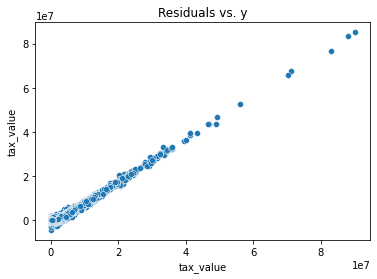

In [17]:
ev.plot_residuals(y_train, predictions)

In [19]:
ev.better_than_baseline(y_train, predictions)

SSE: 3.516821096076405e+17
SSE_baseline: 6.298867608268173e+17
This model performs better than baseline.


## Let's take out outliers

In [20]:
mydf, X_train_exp, X_train, \
y_train, X_validate, y_validate, \
X_test, y_test = w.big_zillow_wrangle('tax_value')

In [21]:
# generate parameters, i.e. create model
ols_model = linear.LinearRegression().fit(X_train, y_train)

# compute predictions and add to original dataframe
predictions = ols_model.predict(X_train)

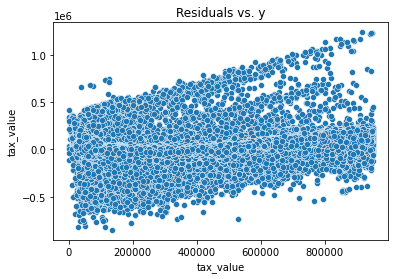

In [22]:
ev.plot_residuals(y_train, predictions)

In [23]:
ev.better_than_baseline(y_train, predictions)

SSE: 4390332651694572.0
SSE_baseline: 4.774035561028734e+16
This model performs better than baseline.


**Lower SSE is better. It means it is closer to the regression line**

In [24]:
validate_pred = ols_model.predict(X_validate)

In [25]:
ev.better_than_baseline(y_validate, validate_pred)

SSE: 1346310763909474.0
SSE_baseline: 1.4673824316444792e+16
This model performs better than baseline.
